In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [189]:
import numpy as np

In [175]:
from collections import OrderedDict

In [176]:
from PIL.Image import Image

In [178]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import (transforms, datasets)

In [182]:
from fastai.vision import *

## Train Letters classificartion with convolutional neural networkm

#### Prepare data

In [121]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])

In [122]:
path = Path('data')

In [123]:
image_path = path / 'geomnist_dataset'

In [ ]:
def img_loader(img_path:Path):
    with open(img_path, mode='rb') as fl:
        with PIL.Image.open(fl) as img:
            return img.convert('L')

In [124]:
train_dataset = datasets.ImageFolder(image_path / 'train_geo', loader=img_loader, transform=tfms)
valid_dataset = datasets.ImageFolder(image_path / 'val_geo', loader=img_loader, transform=tfms)
test_dataset = datasets.ImageFolder(image_path / 'test_geo', loader=img_loader, transform=tfms)

In [149]:
train_dataset, valid_dataset, train_dataset

(Dataset ImageFolder
     Number of datapoints: 27367
     Root location: data/geomnist_dataset/train_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ), Dataset ImageFolder
     Number of datapoints: 9096
     Root location: data/geomnist_dataset/val_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ), Dataset ImageFolder
     Number of datapoints: 27367
     Root location: data/geomnist_dataset/train_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [157]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [158]:
data = DataBunch(train_loader, valid_loader, test_dl=test_loader)

In [159]:
loss_func = nn.CrossEntropyLoss()

In [160]:
learn = Learner(data, model, loss_func=loss_func, metrics=accuracy)

#### Model initialization

In [185]:
?? Flatten

In [186]:
class FlattenLayer(nn.Module):
    """Flatten layer"""

    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.flatten(x, 1)

In [13]:
input_channels=1

In [19]:
lower_body = nn.Sequential(OrderedDict([('conv1', nn.Conv2d(input_channels, 32, 3)),
                                        ('bn1', nn.BatchNorm2d(32)),
                                        ('relu1', nn.ReLU(inplace=True)),
                                        ('mxpl1', nn.MaxPool2d(2, 2)),
                                        ('conv2', nn.Conv2d(32, 64, kernel_size=3)),
                                        ('bn2', nn.BatchNorm2d(64)),
                                        ('relu2', nn.ReLU(inplace=True)),
                                        ('mxpl2', nn.MaxPool2d(2, 2)),
                                        ('drop1', nn.Dropout2d(p=0.25))]))

In [100]:
conv_body = nn.Sequential(OrderedDict([('conv3', nn.Conv2d(64, 128, kernel_size=3)),
                                       ('bn3', nn.BatchNorm2d(128)),
                                       ('relu3', nn.ReLU(inplace=True)),
                                       ('mxpl3', nn.MaxPool2d(2, 2)),
                                       ('drop2', nn.Dropout2d(p=0.25))]))

In [187]:
linear_body = nn.Sequential(OrderedDict([('flatten', FlattenLayer()),
                                         ('ln1', nn.Linear(2 * 2 * 128, 1024, bias=True)),
                                         ('bn2', nn.BatchNorm1d(1024)),
                                         ('relu3', nn.ReLU(inplace=True)),
                                         ('drop2', nn.Dropout(p=0.25))]))

In [227]:
class LetterNet(nn.Module):
    """Full double letters network implementation"""

    def __init__(self, input_channels=1, num_classes=33):
        super(LetterNet, self).__init__()
        self.conv_part = body
        self.dub_part = conv_body
        self.fc_part = linear_body
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv_part(x)
        x = self.dub_part(x)
        x = self.fc_part(x)
        logits = self.fc(x)

        return logits



In [228]:
model = LetterNet()

In [229]:
model

LetterNet(
  (conv_part): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (mxpl1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (mxol2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop1): Dropout2d(p=0.25, inplace=False)
  )
  (dub_part): Sequential(
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (mxpl3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout2d(p=0.25, inplace=False)
  )
  (fc_part): 

In [230]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

## Train model

#### Find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


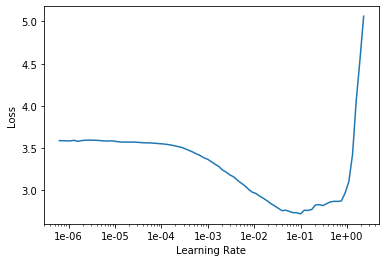

In [231]:
learn.lr_find()
learn.recorder.plot()

In [232]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.824164,0.605432,0.830035,01:33
1,0.559664,0.354223,0.906332,01:36
2,0.355898,0.232563,0.940303,01:35
3,0.215694,0.190429,0.953936,01:40


#### Size dependency

In [251]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [ ]:
model(x_test)

## FastAI for MNIST classifier

In [172]:
def conv2(ni:int, nf:int): 
    return conv_layer(ni,nf,stride=2)

In [201]:
?? conv_layer

In [207]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 33), # 1
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()      # remove (1,1) grid
)

In [208]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(16, 33, kernel_size=(3, 3), stride=(2, 2), paddin

#### Adaptive (global) pooling

In [209]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [210]:
model(x_test)

tensor([[ 0.6306, -0.5707, -0.9175,  0.0440, -0.9462, -0.5773,  0.4013, -0.5770,
         -0.7031,  0.5908,  1.7315, -0.5773, -0.5773, -0.5773, -0.5851,  1.6652,
          1.6728,  1.6348, -0.5820,  0.0473, -0.5212, -0.9873,  1.7309, -0.5773,
         -0.9895,  0.0270,  1.3198, -0.9463,  1.6215,  1.2964, -0.5773, -0.5138,
          1.6842],
        [-1.6077, -0.5806,  0.3553, -0.8308, -0.9462,  1.7320,  1.3281, -0.5770,
          1.7087,  1.0566, -0.5772, -0.5773,  1.7319, -0.5773, -0.5851, -0.1058,
         -0.3868, -0.8147, -0.3774,  1.6166,  0.7179,  1.2113, -0.5770,  1.7320,
         -0.9895,  1.6238, -0.7293,  0.4890, -1.0516,  0.6508, -0.5773,  1.7228,
         -0.2157],
        [ 1.0082,  1.7320, -0.9175, -0.8308,  0.4892, -0.5773, -1.4031, -0.5770,
         -0.7031, -0.0564, -0.5772, -0.5773, -0.5773, -0.5773, -0.5618, -0.7797,
         -0.9785, -0.0054,  1.7163, -0.8320,  1.1652,  0.7634, -0.5770, -0.5773,
          1.1934, -0.8254, -1.1761, -0.9463, -0.5112, -0.9736, -0.5773,

In [211]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [212]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.987037,0.854921,0.762313,00:24
1,0.751318,0.619786,0.821900,00:13
2,0.662653,0.595901,0.837731,00:19
3,0.572874,0.503633,0.855431,00:24
4,0.471681,0.457011,0.873131,00:26
5,0.401058,0.434011,0.876649,00:25
6,0.352574,0.343929,0.906882,00:24
7,0.275898,0.305519,0.918755,00:21
8,0.210955,0.279543,0.926341,00:16
9,0.177266,0.276438,0.928980,00:14


In [170]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

In [214]:
??res_block

In [213]:
def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [217]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

In [218]:
model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    

In [219]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


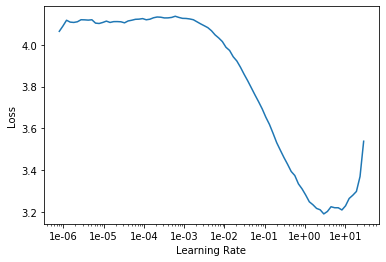

In [220]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [221]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,1.012782,0.810011,0.773197,00:38
1,0.665487,0.614952,0.823769,00:28
2,0.528105,1.186692,0.677441,00:28
3,0.414107,0.412267,0.884675,00:28
4,0.374227,0.344108,0.906882,00:40
5,0.314290,0.280857,0.920515,00:33
6,0.263464,0.345927,0.911719,00:38
7,0.206911,0.227229,0.940413,00:36
8,0.150118,0.205335,0.946020,00:31
9,0.109065,0.183034,0.955805,00:34


## Bigger model with residual connections

In [233]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

In [235]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


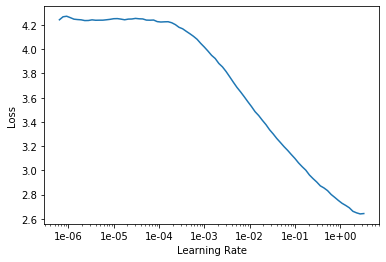

In [236]:
learn.lr_find()
learn.recorder.plot()

In [237]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.774651,0.626832,0.811895,03:58
1,0.443747,0.402485,0.885334,04:32
2,0.236091,0.198303,0.948329,04:32
3,0.134649,0.143767,0.965259,04:19


In [239]:
learn.fit_one_cycle(8, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.182891,0.239913,0.938215,03:42
1,0.288452,0.300819,0.918755,04:04
2,0.266061,0.349663,0.905123,04:16


KeyboardInterrupt: 

#### Add regularization

In [254]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 1024),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer(),
    nn.Linear(1024, 512),
    nn.Dropout(p=0.25),
    nn.Linear(512, 512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 33))

In [255]:
model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [256]:
from utils.logging.time_logger import start_timer

In [257]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [258]:
tm = start_timer(True, model)
y = model(x_test)
tm.timeit()

Time taken for Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=

0.14858599999934086

In [259]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [260]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(28, 2e-2)

## Serialize model

In [240]:
model_path = path / 'models'
model_path.mkdir(exist_ok=True)

In [241]:
model = learn.model

In [244]:
torch.save(model.state_dict(), str(model_path / 'mnist_resnet.pth'))

In [248]:
state_dict = torch.load(str(path / 'models' / 'mnist_resnet.pth'), map_location='cpu')

In [249]:
state_dict

OrderedDict([('0.0.0.weight',
              tensor([[[[-9.5849e-02, -1.0475e+00,  3.2631e-02],
                        [-9.5137e-01, -2.6829e-01, -4.0054e-01],
                        [ 4.0540e-01,  1.1734e+00,  1.3884e-01]]],
              
              
                      [[[ 1.6326e-02, -7.3978e-01, -4.0644e-01],
                        [ 8.3853e-02,  1.3251e+00,  6.5456e-02],
                        [-4.7385e-01, -9.4847e-01, -3.5486e-01]]],
              
              
                      [[[-4.4974e-01, -6.8087e-01, -1.3859e-01],
                        [-8.5928e-01,  3.4980e-01,  9.0930e-01],
                        [-1.5155e-01,  9.5526e-01, -2.6605e-01]]],
              
              
                      [[[ 1.1047e+00, -8.3188e-01, -1.2556e-01],
                        [ 1.3276e-01, -8.8320e-01,  5.2021e-01],
                        [-6.8578e-02,  9.0012e-03, -1.1320e-01]]],
              
              
                      [[[ 2.0896e-01,  1.5602e-01, -3.4772e-02